**Python Version   : 2.7.11** <br>
**Ipython Version  : 4.0.1**

In [1]:
import pylab
import six
import numpy as np

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

# let's embed the plots in the notebook itself
%matplotlib inline

In [2]:
def generate_training_data(number_samples_positive_class, number_samples_negative_class):
    """
    Generates positive and negative training examples and plots them 
    
    Arguments:    
    number_samples_positive_class : number of data points from the positive class, drawn as blue circles
    number_samples_negative_class : number of data points from the negative class, drawn as red circles    
    """
    # creating training data 
    positive_samples = np.ones((number_samples_positive_class, 3))
    negative_samples = np.ones((number_samples_negative_class, 3))

    # sample the training examples from multi-variate normal 
    positive_samples[:,:-1] = np.random.multivariate_normal([1,3], [[1,0],[0,1]], number_samples_positive_class)
    negative_samples[:,:-1] = np.random.multivariate_normal([2,-2.5], [[0.5,0],[0,0.5]], number_samples_negative_class)

    pylab.plot(positive_samples[:,0], positive_samples[:,1], 'bo')
    pylab.plot(negative_samples[:,0], negative_samples[:,1], 'ro')
    pylab.show()
    return positive_samples, negative_samples

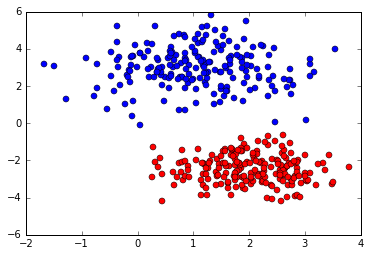

In [3]:
positive_examples, negative_examples = generate_training_data(200,200)

In [4]:
def plot_2d_decision_boundary(positive_samples, negative_samples, weights):
    """
    Plots the provided samples along with a decision boundary defined by the provided weights
    
    Arguments:
    
    positive_samples -- ndarray (num_samples, num_dims) of data points from the positive class, drawn as blue circles
    negative_samples -- ndarray (num_samples, num_dims) of data points from the negative class, drawn as red circles
    weights -- [A,B,C] weights for the line equation, used to draw the decision boundary in green    
    """
    if np.isclose(weights[1], 0):
        if np.isclose(weights[0], 0):
            x = y = np.array([-6, 6], dtype = 'float32')
        else:
            y = np.array([-6, 6], dtype='float32')
            x = -(weights[1] * y + weights[2])/weights[0]
    else:
        x = np.array([-6, 6], dtype='float32')
        y = -(weights[0] * x + weights[2])/weights[1]
        

    pylab.xlim(-6, 6)
    pylab.ylim(-6, 6)                      
    pylab.plot(positive_samples[:,0], positive_samples[:,1], 'bo')
    pylab.plot(negative_samples[:,0], negative_samples[:,1], 'ro')
    pylab.plot(x, y, 'g', linewidth=2.0)

Given an input $\mathbf{x}$, the output of a perceptron is calculated as:

$$y(\mathbf{x}) = f(\mathbf{w}^{\mathrm{T}}\mathbf{x})$$

where $\mathbf{w}$ is the weights on the input vector $\mathbf{x}$ and $f$ is a step function of the form:

$$
f(x) = \begin{cases}
         +1 & x \geq 0 \\
         -1 & x < 0
       \end{cases} \\
$$

$$E_{\mathrm{P}}(\mathbf{w}) = -\sum_{n \in \mathcal{M}}\mathbf{w}^{\mathrm{T}}\mathbf{x}_{n}t_{n}$$

where $t_{n} \in \{-1, +1\}$ for -ve and +ve examples and $\mathcal{M}$ is the set of misclassified examples.
We can use the gradient of this function to update the weights on a per-example basis:

$$\mathbf{w}^{\tau + 1}=\mathbf{w}^{\tau} - \eta \nabla E_{\mathrm{P}}(\mathbf{w}) = \mathbf{w}^{\tau} + \eta \mathbf{x}_{n} t_{n}$$

where $\eta$ is the learning rate 

In [5]:
def train_perceptron(positive_samples, negative_samples, num_iterations = 100):
    """
    Trains a perceptron
    
    Arguments:
    
    positive_samples -- ndarray (num_samples, num_dims) of data points from the positive class
    negative_samples -- ndarray (num_samples, num_dims) of data points from the negative class

    Keyword arguments:
    
    num_iterations -- Number of iterations to run the algorithm.
    
    Returns:
    
    List of snapshots in the form [(step, weights_0, confusion_matrix_0), (weights_1, confusion_matrix_1), ...]    
    """
    num_dims = positive_samples.shape[1]
    weights = np.zeros((num_dims,1)) # initialise the weights
    
    pos_count = positive_samples.shape[0]
    neg_count = negative_samples.shape[0]

    np.set_printoptions(precision=2, suppress=True)
    report_frequency = max(num_iterations / 100, 1)
    
    snapshots = []

    for i in six.moves.range(num_iterations):
        # select a positive and a negative example
        pos = positive_samples[i]
        neg = negative_samples[i]

        # present the positive example
        pos_out = np.dot(pos, weights)
               
        if pos_out < 0:
            # if there was a mistake, update the weights
            weights = weights + pos.reshape(weights.shape)

        # present the negative example
        neg_out = np.dot(neg, weights)
        if neg_out >= 0:
            # if there was a mistake, update the weights
            weights = weights - neg.reshape(weights.shape)
                        
        pos_out = np.dot(positive_samples, weights)
        neg_out = np.dot(negative_samples, weights)        

        pos_correct = (pos_out >= 0).sum() / float(pos_count)
        neg_correct = (neg_out < 0).sum() / float(neg_count)

        confusion_matrix = np.zeros((2,2))
        confusion_matrix[0,0] = pos_correct
        confusion_matrix[0,1] = 1 - pos_correct
        confusion_matrix[1,1] = neg_correct
        confusion_matrix[1,0] = 1 - neg_correct
            
        print np.average(confusion_matrix.diagonal())
                        
        snapshots.append((np.copy(weights), confusion_matrix))            

    return snapshots

In [6]:
def training_slideshow_points(step):
    fig = pylab.figure(figsize=(10,4))
    fig.add_subplot(1, 2, 1)
    plot_2d_decision_boundary(positive_examples, negative_examples, snapshots[step][0])
    fig.add_subplot(1, 2, 2)
    pylab.plot(np.arange(len(averages)), averages)
    pylab.ylabel('Accuracy')
    pylab.xlabel('Iteration')
    pylab.plot(step, averages[step], "bo")
    pylab.show()

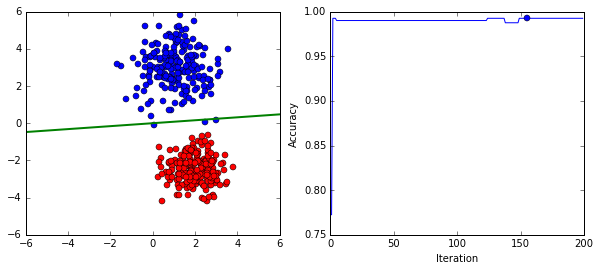

In [7]:
snapshots = train_perceptron(positive_examples, negative_examples, 200)
averages = [np.average(confusion_matrix.diagonal()) for (weights, confusion_matrix) in snapshots]

interact(training_slideshow_points, step=widgets.IntSlider(value=0, min=0, max=len(snapshots)-1))